In [286]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy.stats import randint
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the activity data
activity_train = pd.read_csv('activity_train.csv', header=None)
activity_train.columns = ['Protein', 'Molecule', 'Activity']

activity_blanked = pd.read_csv('activity_test_blanked.csv', header=None)
activity_blanked.columns = ['Protein', 'Molecule', 'Activity']

# Strip any leading or trailing spaces from Molecule identifiers
activity_train['Molecule'] = activity_train['Molecule'].str.strip().str.upper()
activity_blanked['Molecule'] = activity_blanked['Molecule'].str.strip().str.upper()

# Load molecular features
with open('mol_bits.pkl', 'rb') as file:
    mol_bits = pickle.load(file)

# Prepare the sparse matrix for molecular features
vector_size = 2048
rows, cols, data = [], [], []
for i, (mol, bits) in enumerate(mol_bits.items()):
    rows.extend([i] * len(bits))
    cols.extend(bits)
    data.extend([1] * len(bits))

mol_features_sparse = csr_matrix((data, (rows, cols)), shape=(len(mol_bits), vector_size), dtype=np.float32)

In [289]:
# Convert to dense format and create a DataFrame
mol_features_df = pd.DataFrame.sparse.from_spmatrix(mol_features_sparse)
mol_features_df.columns = [f'bit_{i}' for i in range(vector_size)]
mol_features_df['Molecule'] = list(mol_bits.keys())

In [290]:
# Merge with molecular features
activity_train = activity_train.merge(mol_features_df, on='Molecule')
activity_blanked = activity_blanked.merge(mol_features_df, on='Molecule')

In [291]:
# Extract unique molecules and proteins from both datasets
unique_molecules = pd.unique(activity_train['Molecule'].append(activity_blanked['Molecule']))
unique_proteins = pd.unique(activity_train['Protein'].append(activity_blanked['Protein']))

In [292]:
# Create categorical types from the unique lists
molecule_categories = pd.Categorical(unique_molecules)
protein_categories = pd.Categorical(unique_proteins)

In [293]:
# Create mappings
molecule_mapping = {category: code for code, category in enumerate(molecule_categories)}
protein_mapping = {category: code for code, category in enumerate(protein_categories)}

In [294]:
# Create reverse mappings
reverse_molecule_mapping = {v: k for k, v in molecule_mapping.items()}
reverse_protein_mapping = {v: k for k, v in protein_mapping.items()}

In [295]:
# Apply the mappings to both datasets
activity_train['Molecule'] = activity_train['Molecule'].map(molecule_mapping)
activity_train['Protein'] = activity_train['Protein'].map(protein_mapping)

activity_blanked['Molecule'] = activity_blanked['Molecule'].map(molecule_mapping)
activity_blanked['Protein'] = activity_blanked['Protein'].map(protein_mapping)

In [296]:
# Split the data into training and testing sets
X = activity_train.drop(columns=['Activity'])
y = activity_train['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Sample a subset of the data (e.g., 50%)
subset_fraction = 0.5
subset_data = activity_features.sample(frac=subset_fraction, random_state=42)

# Split the subset data into training and testing sets
X_subset = subset_data.drop(columns=['Activity'])
y_subset = subset_data['Activity']
X_subset_train, X_subset_test, y_subset_train, y_subset_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Initialize the Random Forest model
model = RandomForestRegressor(random_state=42)

# Set up the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11)
}

# Perform randomized search on the subset
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=2, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_subset_train, y_subset_train)
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')


/Users/sonamoravcikova/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/sonamoravcikova/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/sonamoravcikova/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/sonamoravcikova/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/sonamoravcikova/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns fou

Best Parameters: {'max_depth': 30, 'min_samples_split': 6, 'n_estimators': 107}


In [146]:
# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42,  n_jobs=-1)
model.fit(X_train, y_train)

/Users/sonamoravcikova/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


RandomForestRegressor(n_jobs=-1, random_state=42)

In [147]:
# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


/Users/sonamoravcikova/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Mean Squared Error: 2.4611090299524734


In [301]:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Reset indices to align correctly
X_test = X_test.reset_index(drop=True)
comparison = comparison.reset_index(drop=True)

# Add Molecule and Protein names back to the comparison DataFrame
X_test_with_names = X_test.copy()
X_test_with_names['Molecule_Name'] = X_test['Molecule'].map(reverse_molecule_mapping)
X_test_with_names['Protein_Name'] = X_test['Protein'].map(reverse_protein_mapping)

# Ensure the indices are aligned and merge the DataFrames
comparison_with_names = pd.concat([X_test_with_names[['Molecule_Name', 'Protein_Name']], comparison], axis=1)

# Display the comparison DataFrame with actual names
print("\nComparison DataFrame with Actual Names:")
print(comparison_with_names.head(10))


Comparison DataFrame with Actual Names:
   Molecule_Name Protein_Name  Actual  Predicted
0   CHEMBL270876       Q92847       3   5.835722
1   CHEMBL404348       P30542       1   1.231470
2  CHEMBL3262091       P41146       4   5.798712
3  CHEMBL1923762       P34972       3   3.891353
4  CHEMBL1668272       P42345       3   5.653132
5  CHEMBL3219941       P41145       4   3.781947
6   CHEMBL411437       P14416       5   3.794569
7   CHEMBL598551       P29274       3   2.751707
8  CHEMBL3695432       P35462       8   7.762702
9    CHEMBL21536       P08912       5   4.839691


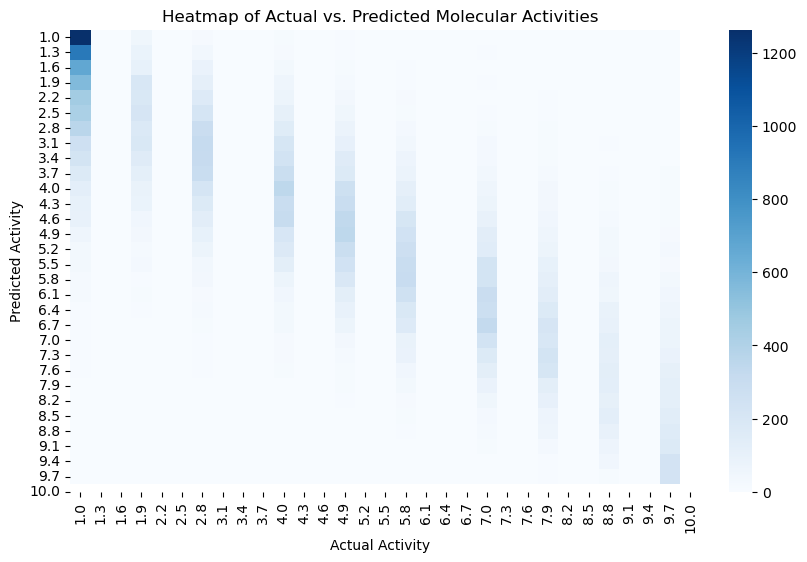

In [310]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D histogram for Actual vs. Predicted values
heatmap_data, xedges, yedges = np.histogram2d(comparison['Actual'], comparison['Predicted'], bins=30)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.T, cmap='Blues', xticklabels=np.round(xedges, 2), yticklabels=np.round(yedges, 2))
plt.xlabel('Actual Activity')
plt.ylabel('Predicted Activity')
plt.title('Heatmap of Actual vs. Predicted Molecular Activities')
plt.show()

In [254]:
# Check feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importances.sort_values(by='Importance', ascending=False).head(10))

       Feature  Importance
0      Protein    0.143341
1     Molecule    0.111464
632    bit_630    0.013025
1327  bit_1325    0.010107
891    bit_889    0.008598
1604  bit_1602    0.007512
336    bit_334    0.006691
1484  bit_1482    0.005344
877    bit_875    0.004245
937    bit_935    0.003750


### Using model to predict activity_test_blanked

In [279]:
#Train model on whole Train dataset
model = RandomForestRegressor(n_estimators=100, random_state=42,  n_jobs=-1)
model.fit(X, y)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [281]:
X_blanked = activity_blanked.drop(columns=['Activity'])
y_blanked_pred = model.predict(X_blanked)

In [282]:
activity_blanked['Predicted_Activity'] = y_blanked_pred
# Convert the codes back to names
activity_blanked['Molecule_Name'] = activity_blanked['Molecule'].map(reverse_molecule_mapping)
activity_blanked['Protein_Name'] = activity_blanked['Protein'].map(reverse_protein_mapping)

In [283]:
# Create a new DataFrame with only the relevant columns
predicted_activities = activity_blanked[['Protein_Name', 'Molecule_Name', 'Predicted_Activity']]

In [284]:
# Create a dictionary for quick lookup of predicted activities
predicted_dict = {(row['Protein_Name'], row['Molecule_Name']): row['Predicted_Activity'] for _, row in predicted_activities.iterrows()}

#Update the orginial file with predictions
activity_test_blanked = pd.read_csv('activity_test_blanked.csv', header=None)
activity_test_blanked.columns = ['Protein_Name', 'Molecule_Name', 'Activity']
activity_test_blanked['Molecule_Name'] = activity_test_blanked['Molecule_Name'].str.strip().str.upper()

# Update the Activity column in activity_test_blanked using the predicted_dict
activity_test_blanked['Activity'] = activity_test_blanked.apply(lambda row: predicted_dict.get((row['Protein_Name'], row['Molecule_Name']), row['Activity']), axis=1)

In [285]:
# Drop the column names and save the DataFrame to a txt file
activity_test_blanked.to_csv('preds_05.txt', index=False, header=False)
# Drop the column names and save the DataFrame to a CSV file
activity_test_blanked.to_csv('preds_05.csv', index=False, header=False)